In [1]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

    # iOS
    'aws-amplify/amplify-ios',
    'aws-amplify/aws-sdk-ios',
    'awslabs/aws-mobile-appsync-sdk-ios',
    
    # JS
    'aws-amplify/amplify-js',
    
    # CLI
    'aws-amplify/amplify-cli',
    
    # Docs
    'aws-amplify/docs'
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [2]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [3]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [4]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']['nodes'])
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [5]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [6]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,34,33,1,28,6,6,22


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,15,15,0,13,2,3,12
1,Bug,API,2,2,0,2,0,0,1
2,Bug,Amplify Gradle Plugin,1,1,0,1,0,0,1
3,Bug,Analytics,1,0,1,0,1,0,0
4,Bug,Auth,3,3,0,2,1,1,4
5,Bug,DataStore,6,7,-1,6,0,2,5
6,Bug,Storage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,12,14,-2,11,1,2,2
1,Feature Request,API,6,6,0,4,2,0,0
2,Feature Request,Amplify Gradle Plugin,1,1,0,1,0,0,0
3,Feature Request,Auth,1,2,-1,1,0,1,1
4,Feature Request,Core,1,1,0,1,0,0,0
5,Feature Request,DataStore,4,4,0,2,2,0,0
6,Feature Request,Predictions,1,1,0,1,0,0,0
7,Feature Request,Storage,1,2,-1,2,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,5,3,2,3,2,1,6
1,Other,Auth,0,0,0,1,-1,0,1
2,Other,DataStore,1,1,0,1,0,0,1
3,Other,RFC,2,2,0,1,1,0,1
4,Other,Storage,0,0,0,0,0,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,2,1,1,1,1,0,2
1,Question,API,1,1,0,1,0,0,0
2,Question,Auth,0,0,0,0,0,0,2


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,146,153,-7,152,-6,13,22


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,38,39,-1,39,-1,4,8
1,Bug,AWSMobileClient,12,12,0,12,0,1,4
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,5,0,0,0
4,Bug,Core,1,1,0,1,0,0,0
5,Bug,IoT,3,3,0,3,0,0,0
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,3,0,3,0,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,6,7,-1,7,-1,3,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,64,66,-2,65,-1,2,2
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,16,17,-1,17,-1,1,1
3,Feature Request,Cognito,13,14,-1,14,-1,1,1
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,IoT,12,12,0,11,1,0,0
7,Feature Request,KinesisVideo,1,1,0,1,0,0,0
8,Feature Request,Lambda,1,1,0,1,0,0,0
9,Feature Request,Other AWS Services,3,3,0,3,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,16,16,0,17,-1,3,7
1,Other,AWSMobileClient,7,9,-2,9,-2,2,2
2,Other,Cognito,3,4,-1,4,-1,1,1
3,Other,DynamoDB,1,1,0,1,0,0,0
4,Other,IoT,1,1,0,1,0,0,0
5,Other,Sample App,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,0,0,0,0,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,28,32,-4,31,-3,4,5
1,Question,APIGateway,4,4,0,3,1,0,0
2,Question,AWSMobileClient,11,15,-4,15,-4,4,5
3,Question,Cognito,6,6,0,5,1,0,0
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,IoT,2,2,0,2,0,0,0
7,Question,KinesisVideo,1,1,0,1,0,0,0
8,Question,Pinpoint,2,2,0,2,0,0,0
9,Question,S3,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,56,55,1,51,5,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,21,21,0,20,1,0,0
1,Bug,AppSync,19,19,0,19,0,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,14,14,0,14,0,0,0
1,Feature Request,AppSync,13,13,0,13,0,0,0
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,12,11,1,8,4,0,2
1,Other,AppSync,2,2,0,2,0,0,0
2,Other,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,9,9,0,9,0,0,0
1,Question,AppSync,9,9,0,9,0,0,0
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-ios,87,81,6,85,2,5,28


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,13,14,-1,18,-5,1,9
1,Bug,api,2,2,0,3,-1,0,2
2,Bug,auth,1,1,0,3,-2,0,2
3,Bug,build,1,1,0,1,0,0,0
4,Bug,core,0,1,-1,0,0,1,1
5,Bug,datastore,10,10,0,12,-2,0,3
6,Bug,follow up,5,5,0,6,-1,0,1
7,Bug,pending investigation,1,1,0,1,0,0,0
8,Bug,pending release,0,1,-1,2,-2,1,4
9,Bug,pending triage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,32,28,4,29,3,1,3
1,Feature Request,analytics,2,2,0,2,0,0,0
2,Feature Request,api,10,8,2,8,2,0,0
3,Feature Request,auth,2,2,0,2,0,0,0
4,Feature Request,core,3,3,0,4,-1,0,1
5,Feature Request,datastore,20,15,5,15,5,0,0
6,Feature Request,documentation,1,1,0,1,0,0,0
7,Feature Request,feature request,1,1,0,1,0,0,0
8,Feature Request,follow up,1,1,0,1,0,0,0
9,Feature Request,pending investigation,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,42,39,3,38,4,3,16
1,Other,analytics,1,1,0,1,0,0,0
2,Other,api,14,12,2,10,4,0,4
3,Other,auth,5,4,1,8,-3,0,7
4,Other,build,3,3,0,3,0,1,1
5,Other,closing soon,2,2,0,6,-4,0,4
6,Other,contribution,1,1,0,1,0,0,0
7,Other,core,4,3,1,4,0,0,1
8,Other,datastore,17,15,2,14,3,1,2
9,Other,documentation,5,7,-2,7,-2,2,3


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-ios,214,213,1,201,13,5,13


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,40,41,-1,39,1,2,5
1,Bug,APIGateway,1,1,0,1,0,0,0
2,Bug,AWSMobileClient,7,7,0,6,1,1,1
3,Bug,AppSync,2,2,0,2,0,0,0
4,Bug,Build,2,2,0,1,1,0,1
5,Bug,Cognito,4,4,0,3,1,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,Documentation,1,1,0,1,0,0,0
8,Bug,IoT,11,11,0,12,-1,0,2
9,Bug,Pinpoint,4,4,0,4,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,85,86,-1,87,-2,2,3
1,Feature Request,APIGateway,4,4,0,4,0,0,0
2,Feature Request,AWSMobileClient,22,22,0,23,-1,1,2
3,Feature Request,Build,2,2,0,2,0,0,0
4,Feature Request,Cognito,20,21,-1,21,-1,1,1
5,Feature Request,Core,1,1,0,1,0,0,0
6,Feature Request,Documentation,1,1,0,1,0,0,0
7,Feature Request,DynamoDB,1,1,0,1,0,0,0
8,Feature Request,Infrastructure,2,2,0,2,0,0,0
9,Feature Request,IoT,8,8,0,8,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,48,45,3,38,10,1,5
1,Other,APIGateway,1,1,0,1,0,0,0
2,Other,AWSMobileClient,9,8,1,8,1,1,2
3,Other,AppSync,1,1,0,1,0,0,0
4,Other,Build,4,4,0,3,1,0,1
5,Other,Cognito,14,13,1,12,2,0,0
6,Other,Core,1,1,0,1,0,0,0
7,Other,Infrastructure,1,1,0,1,0,0,0
8,Other,IoT,3,3,0,3,0,0,0
9,Other,Lex,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,41,41,0,37,4,0,0
1,Question,APIGateway,2,2,0,2,0,0,0
2,Question,AWSMobileClient,5,5,0,3,2,0,0
3,Question,AppSync,1,1,0,1,0,0,0
4,Question,Cognito,10,10,0,10,0,0,0
5,Question,Core,1,1,0,1,0,0,0
6,Question,Documentation,1,1,0,1,0,0,0
7,Question,FrameworkBuild,1,1,0,1,0,0,0
8,Question,IoT,3,3,0,3,0,0,0
9,Question,KMS,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-ios,64,65,-1,68,-4,1,4


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,20,21,-1,23,-3,1,3
1,Bug,AppSync,19,20,-1,20,-1,1,1
2,Bug,Documentation,1,1,0,1,0,0,0
3,Bug,Service,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,21,21,0,21,0,0,0
1,Feature Request,AppSync,19,19,0,19,0,0,0
2,Feature Request,Build,1,1,0,1,0,0,0
3,Feature Request,Documentation,3,3,0,3,0,0,0
4,Feature Request,Infrastructure,1,1,0,1,0,0,0
5,Feature Request,tvOS,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,9,9,0,9,0,0,0
1,Other,AppSync,7,7,0,7,0,0,0
2,Other,Build,1,1,0,1,0,0,0
3,Other,Documentation,1,1,0,1,0,0,0
4,Other,Tests,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,14,14,0,15,-1,0,1
1,Question,AppSync,12,12,0,12,0,0,0
2,Question,Build,1,1,0,1,0,0,0
3,Question,Documentation,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-js,645,637,8,622,23,12,90


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,31,31,0,36,-5,0,9
1,Bug,Amplify UI Components,4,4,0,3,1,0,1
2,Bug,Angular,1,1,0,3,-2,0,2
3,Bug,Auth,4,4,0,7,-3,0,3
4,Bug,Browser Compatibly,1,1,0,2,-1,0,1
5,Bug,Cognito,8,8,0,8,0,0,0
6,Bug,Core,1,1,0,1,0,0,0
7,Bug,DataStore,8,8,0,8,0,0,2
8,Bug,Federation,1,1,0,2,-1,0,1
9,Bug,GraphQL,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,393,392,1,381,12,3,16
1,Feature Request,API,18,18,0,16,2,0,0
2,Feature Request,Amplify UI Components,28,27,1,25,3,0,2
3,Feature Request,Analytics,14,14,0,14,0,0,0
4,Feature Request,Angular,14,14,0,14,0,0,0
5,Feature Request,AppSync,6,6,0,6,0,0,0
6,Feature Request,Auth,87,88,-1,88,-1,1,3
7,Feature Request,Build,3,3,0,3,0,0,0
8,Feature Request,Caching,1,1,0,1,0,0,0
9,Feature Request,Cognito,54,54,0,52,2,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,70,74,-4,80,-10,6,30
1,Other,API,4,6,-2,5,-1,2,2
2,Other,Amplify UI Components,7,9,-2,9,-2,2,6
3,Other,Analytics,1,1,0,1,0,0,0
4,Other,Angular,3,3,0,2,1,0,0
5,Other,AppSync,4,4,0,4,0,0,1
6,Other,Auth,31,34,-3,33,-2,3,8
7,Other,Can't reproduce,2,2,0,4,-2,0,3
8,Other,Cognito,20,20,0,20,0,0,0
9,Other,DataStore,7,8,-1,5,2,1,6


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,109,98,11,77,32,2,23
1,Pending Triage,API,6,7,-1,3,3,2,3
2,Pending Triage,Amplify UI Components,5,4,1,1,4,0,0
3,Pending Triage,Analytics,7,7,0,5,2,0,0
4,Pending Triage,Angular,3,3,0,3,0,0,0
5,Pending Triage,AppSync,1,1,0,1,0,0,0
6,Pending Triage,Auth,53,47,6,36,17,0,3
7,Pending Triage,Build,1,1,0,2,-1,0,1
8,Pending Triage,Cognito,4,4,0,2,2,0,0
9,Pending Triage,Core,2,2,0,2,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,42,42,0,48,-6,1,12
1,Question,API,2,2,0,2,0,0,0
2,Question,Amplify UI Components,0,0,0,0,0,1,1
3,Question,Analytics,1,1,0,1,0,0,0
4,Question,Angular,4,4,0,4,0,0,0
5,Question,AppSync,5,5,0,6,-1,0,1
6,Question,Auth,16,16,0,17,-1,0,5
7,Question,Cognito,6,6,0,6,0,0,1
8,Question,DataStore,3,3,0,4,-1,0,1
9,Question,GraphQL,4,4,0,4,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-cli,749,741,8,714,35,23,123


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,91,90,1,98,-7,2,24
1,Bug,@auth,4,4,0,4,0,0,1
2,Bug,@connection,0,0,0,1,-1,0,1
3,Bug,@key,5,5,0,4,1,0,0
4,Bug,@searchable,0,0,0,1,-1,0,1
5,Bug,DataStore,2,2,0,2,0,0,1
6,Bug,Lambda layers,1,1,0,1,0,0,0
7,Bug,amplify-app,0,0,0,1,-1,0,1
8,Bug,amplify-console,1,0,1,0,1,0,0
9,Bug,analytics,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,528,519,9,501,27,1,7
1,Feature Request,@auth,6,6,0,6,0,0,0
2,Feature Request,@connection,2,1,1,1,1,0,0
3,Feature Request,@key,7,7,0,7,0,0,0
4,Feature Request,@model,1,1,0,1,0,0,0
5,Feature Request,@searchable,7,7,0,6,1,0,0
6,Feature Request,DataStore,9,9,0,9,0,0,0
7,Feature Request,Lambda layers,1,1,0,1,0,0,0
8,Feature Request,RFC,5,5,0,5,0,0,0
9,Feature Request,amplify-console,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,88,84,4,72,16,13,68
1,Other,@auth,8,8,0,7,1,2,3
2,Other,@connection,1,0,1,0,1,0,1
3,Other,@key,0,0,0,1,-1,0,1
4,Other,@searchable,3,2,1,3,0,0,2
5,Other,DataStore,1,1,0,1,0,0,0
6,Other,Lambda layers,2,2,0,1,1,0,2
7,Other,RFC,5,5,0,5,0,0,0
8,Other,amplify-console,1,1,0,1,0,0,0
9,Other,analytics,2,2,0,1,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,42,48,-6,43,-1,7,24
1,Question,@auth,1,2,-1,2,-1,2,2
2,Question,@key,2,2,0,1,1,0,0
3,Question,@searchable,1,2,-1,0,1,1,1
4,Question,DataStore,3,3,0,3,0,0,0
5,Question,analytics,2,2,0,1,1,0,0
6,Question,api-graphql,1,1,0,0,1,0,0
7,Question,api-rest,1,2,-1,0,1,1,1
8,Question,aurora,1,1,0,1,0,0,0
9,Question,auth,6,6,0,6,0,0,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/docs,81,77,4,75,6,11,41


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,1,1,0,1,0,0,2
1,Bug,Android,0,0,0,0,0,0,1
2,Bug,CLI,1,1,0,1,0,0,0
3,Bug,Getting Started,0,0,0,0,0,0,2
4,Bug,iOS,0,0,0,0,0,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,14,-1,12,1,1,3
1,Feature Request,Android,1,1,0,1,0,0,0
2,Feature Request,Auth,1,1,0,0,1,0,0
3,Feature Request,CLI,4,4,0,3,1,0,0
4,Feature Request,Docs Site (Itself),2,2,0,3,-1,0,2
5,Feature Request,JavaScript,6,6,0,3,3,0,0
6,Feature Request,iOS,1,1,0,1,0,0,0
7,Feature Request,pending-close-if-no-response,0,0,0,2,-2,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,67,62,5,62,5,10,36
1,Other,Android,3,2,1,1,2,0,2
2,Other,Auth,4,4,0,2,2,0,0
3,Other,CLI,12,12,0,13,-1,0,3
4,Other,Detailed Needed from Requester,2,2,0,0,2,2,4
5,Other,Docs Site (Itself),1,2,-1,2,-1,1,1
6,Other,Flutter,2,0,2,0,2,0,0
7,Other,Getting Started,3,3,0,0,3,0,1
8,Other,JavaScript,42,37,5,33,9,0,2
9,Other,UI,6,6,0,6,0,1,2


In [7]:
##### Top Open Bugs by Activity

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(15))

,id,title,created_at,labels,score
64,464,Synchronization Error with relations,2020-05-14 20:46:43+00:00,"[Bug, DataStore]",10
68,487,DataStore multiple one has many relation error,2020-05-19 14:46:42+00:00,"[Bug, DataStore]",9
123,657,Amplify.addPlugin produces a crash when I start my app for API level lower than 21,2020-07-21 00:00:48+00:00,[Bug],8
148,731,Websocket connection failed when trying to subscribe,2020-08-17 12:43:55+00:00,"[Bug, DataStore]",8
151,748,Social sign in crashes the browser without any error messages,2020-08-22 15:23:53+00:00,"[Auth, Bug, Closing Soon]",8
63,461,DataStore initial sync fails when using relations & DynamoDB tables have too many records,2020-05-14 11:51:02+00:00,"[Bug, DataStore]",6
124,666,"""createdAt: AWSDateTime"" in schema causes Datastore query failure",2020-07-24 13:16:32+00:00,"[Bug, DataStore]",6
134,683,Unable to login on user created from cognito console,2020-07-30 12:50:52+00:00,"[Auth, Bug]",6
73,536,ERROR: Node.js is not installed (EACCESS error),2020-05-27 13:44:33+00:00,"[Amplify Gradle Plugin, Bug]",4
112,629,Access Denied | Store data in S3 bucket,2020-07-07 17:02:19+00:00,"[Bug, Storage]",2


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with Android < 7,2019-10-16 19:36:15+00:00,"[Bug, IoT]",51
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[AWSMobileClient, Bug]",27
985,2063,Could not check if ACCESS_NETWORK_STATE permission is available warning in 2.17.1,2020-08-11 22:31:33+00:00,"[AWSMobileClient, Bug]",26
695,1003,AWSMobileClient.getInstance().showSignIn() buttons do not work after sign-out or invalid token,2019-06-02 04:34:37+00:00,"[AWSMobileClient, Bug]",22
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",15
803,1264,NullPointerException Attempt to invoke virtual method 'java.lang.String com.amazonaws.services.cognitoidentityprovider.model.CodeDeliveryDetailsType.getDestination()' on a null object reference,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",15
955,1827,No cached session if app is inactive for some time,2020-06-05 14:07:23+00:00,"[AWSMobileClient, Bug]",10
886,1495,getUsername() returning null,2020-02-29 19:51:26+00:00,"[AWSMobileClient, Bug]",6
791,1232,"S3 GetObject request failing with ""More data read(78279) than expected"" error.",2019-10-04 06:53:24+00:00,"[Bug, S3]",6
966,1947,Uploading large files to aws s3 almost always fails.,2020-06-26 05:08:59+00:00,"[Bug, Needs Info from Requester, S3]",5


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid message type string"" exception when token has expired",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",12
150,257,Subscriptions don't work in 3.0.x; NullPointerException on AWSConfiguration object,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",8
86,136,IOException/SocketTimeoutException not propagated to GraphQLCall.Callback and Appsync goes into a long loop of retrying,2019-03-26 18:42:58+00:00,"[AppSync, Bug]",8
123,207,Delta sync base query always runs again after process restart,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",8
119,203,AppSync submits mutations with big delays,2019-07-17 23:07:16+00:00,"[AppSync, Bug]",6
78,127,Apollo mapping not working with Appsync Gradle plugin 2.7.8,2019-03-07 11:58:12+00:00,"[AppSync, Bug, Codegen]",6
104,163,Multidimensional array support,2019-04-29 12:43:50+00:00,"[AppSync, Bug, Codegen]",5
126,211,"When subscribing, getting - ApolloException: Connection Error Reported",2019-08-26 11:07:45+00:00,"[AppSync, Bug]",5
93,147,Fatal Exception: android.database.sqlite.SQLiteDatabaseLockedException,2019-04-11 11:06:09+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
195,591,API: Error deserializing from error response,2020-06-28 21:10:50+00:00,"[bug, datastore, follow up]",16
155,507,"Error: ""The key __typename was not found"" when using DataStore with existing data in database.",2020-06-02 15:30:51+00:00,"[bug, datastore, follow up]",13
222,640,credentialsFetchLock.leave() - Federated sign in crash,2020-07-12 23:05:41+00:00,"[auth, bug, follow up]",12
154,505,Incorrect codegen error - DataStore does not support 1 to 1 connection with both sides of connection as optional field,2020-06-01 16:24:46+00:00,"[bug, datastore]",8
153,504,Codegen produces compile error - Value type 'PhoneCall' cannot have a stored property that recursively contains it,2020-06-01 16:14:23+00:00,"[bug, datastore, follow up]",6
198,595,Saving empty embedded collection of Message model does not work,2020-06-29 20:20:27+00:00,"[api, bug, datastore]",6
225,645,"Return Error Status when attempting Datastore mutation, CognitoUserPools logged out state",2020-07-15 17:12:08+00:00,"[bug, datastore, follow up]",4
149,500,Amplify Tool fails if I have multiple AWS profile and default is not valid,2020-05-29 20:44:33+00:00,"[bug, build, pending triage]",3
188,576,DataStore SyncEngine completely fails when at least one subscription fails.,2020-06-23 20:50:09+00:00,"[bug, datastore, pending investigation]",2
210,622,DataStore sync failing for connected Model without auth directive,2020-07-07 18:14:12+00:00,"[api, bug, datastore]",2


,id,title,created_at,labels,score
1422,2313,"AWS IoT crashes, but never while connected to the debugger",2020-02-25 04:38:14+00:00,"[IoT, bug]",25
1569,2906,Unable to build with Carthage and Xcode 12 beta 3,2020-08-03 19:52:55+00:00,"[Build, bug]",22
1416,2298,Imported User (RESET_REQUIRED) throws InvalidParameterException on signIn,2020-02-20 07:33:21+00:00,"[Cognito, Service, bug]",21
1080,1278,Crash in AWSMobileClient.getTokens(),2019-03-11 21:52:03+00:00,"[AWSMobileClient, bug]",15
1576,2927,Build failure with 2.15.x in Xcode 12,2020-08-11 00:10:52+00:00,"[Build, bug]",15
1023,1209,Crash in AWSIoTMQTTClient.m line 635 -[AWSIoTMQTTClient openStreams:],2019-01-31 07:21:23+00:00,"[IoT, bug]",12
1031,1217,Crash in AWSAuthCore *** -[__NSPlaceholderDictionary initWithObjects:forKeys:count:]: attempt to insert nil object from objects[0],2019-02-07 07:29:10+00:00,"[AWSMobileClient, bug]",12
1262,1740,Generated API.swift sends mimeType and localUri from S3ObjectTypeInput with mutation.,2019-08-01 20:37:43+00:00,"[AppSync, Investigating, bug]",11
1564,2886,Canceling signOut() in hosted UI alert pop-up leaves inconsistent user state,2020-07-28 17:41:35+00:00,"[AWSMobileClient, bug]",8
1464,2389,Threadlock after switching default user pools,2020-03-27 10:26:57+00:00,"[bug, question]",8


,id,title,created_at,labels,score
87,173,AWSPerformMutationOperation causes high CPU usage and freezes UI,2019-02-08 21:40:45+00:00,"[AppSync, Bug, Investigating]",25
96,189,Mutation is lost when network connection is bad,2019-02-27 19:09:18+00:00,"[AppSync, Bug, Investigating]",11
121,221,no callback to mutation,2019-04-07 02:17:01+00:00,"[AppSync, Bug]",10
118,218,lastSyncTime is updated after first page of results of sync,2019-04-03 13:28:55+00:00,"[AppSync, Bug]",6
144,268,Problem with Fetch Queries in AppSync iOS,2019-06-21 18:57:07+00:00,"[AppSync, Bug]",5
117,217,Can't initialize two delta sync operations in a row,2019-04-03 11:54:10+00:00,"[AppSync, Bug]",5
203,375,Subscription AWSJSON fields are double encoded,2020-04-01 09:10:07+00:00,"[AppSync, Bug]",4
90,180,Setting property to nil via generated Swift api is ignored,2019-02-13 18:25:22+00:00,"[AppSync, Bug]",4
182,329,2.12+ of AppSync consumes all of the app memory and then crashes,2020-01-28 09:58:28+00:00,"[AppSync, Bug]",3
133,244,SQLite can easily be corrupted when making many fetch calls,2019-04-27 00:32:25+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
3702,6108,DataStore with @auth - Sync error subscription failed ... Missing field argument owner,2019-12-20 08:37:36+00:00,"[DataStore, bug]",127
2591,4089,support RN-0.60.+ for @aws-amplify/pushnotification,2019-09-26 16:34:03+00:00,"[Push Notifications, React Native, bug]",67
2675,4257,GraphQLResult and Observable<object> incorrect types for API.graphql,2019-10-25 04:09:48+00:00,"[GraphQL, bug]",60
2648,4197,Amplify currentUserinfo returns null,2019-10-17 03:45:24+00:00,"[Cognito, Service Team, bug]",53
2738,4346,Amplify auth signIn throws Cors error on Microsoft Edge,2019-11-05 16:36:10+00:00,"[Browser Compatibly, Cognito, bug]",40
2672,4244,React-native Auth.federatedSignIn() redirection URL mismatch error,2019-10-24 12:53:29+00:00,"[Auth, React Native, bug]",39
3453,5623,Custom auth lambda trigger is not configured for the user pool.,2020-04-29 20:45:07+00:00,"[Amplify UI Components, Auth, bug]",24
2186,3431,Delete linked user from User pool users.,2019-06-11 18:24:57+00:00,"[Cognito, Service Team, bug]",21
3930,6580,DataStore upgrading from 2.2.6 to 2.2.7+ breaks realtime data,2020-08-14 17:55:57+00:00,"[DataStore, bug]",19
745,1226,Auth.setupTOTP silently disables TOTP if it's currently enabled,2018-07-12 21:57:15+00:00,"[Cognito, Service Team, bug]",17


,id,title,created_at,labels,score
399,682,Error: Only one resolver is allowed per field,2019-01-09 09:04:54+00:00,"[bug, dependency-issue, graphql-transformer]",137
1218,1874,Get apiaivyGraphQLAPIIdOutput in auto generated PostConfirmation Lambda?,2019-07-20 16:26:02+00:00,"[bug, functions]",110
2083,3284,Peer dependency missing,2020-01-27 20:24:32+00:00,"[bug, dependency-issue, interactions]",37
3265,5139,"Models not saving due to incorrect data model, again.",2020-03-04 19:06:15+00:00,"[DataStore, bug]",27
2506,3967,AWSJSON update not working correctly,2020-04-15 16:51:14+00:00,"[bug, graphql-transformer]",25
1967,3108,amplify codegen model adds non-existent Id field and ignores the key definition,2020-01-02 16:37:06+00:00,"[DataStore, bug, code-gen]",21
1420,2199,AWSDateTime scalar is not currently supported by RDS datetime type,2019-09-03 13:53:57+00:00,"[bug, dependency-issue, graphql-transformer]",20
1815,2841,Add user to group error,2019-11-26 17:15:12+00:00,"[auth, bug, pending-response]",19
3091,4886,So Lambda Layers are not multienv and not actually deleted after remove?,2020-07-21 00:52:52+00:00,"[Lambda layers, bug, functions]",18
2567,4066,Changes to resources during 'push' can lead to 'no changes' message,2020-04-24 12:27:53+00:00,"[bug, platform]",18


,id,title,created_at,labels,score
475,1910,"Error in the section ""Ownership with create mutations""",2020-06-03 19:08:16+00:00,"[Bug, CLI]",2


,id,title,created_at,labels,score
125,667,Support OIDC providers via @auth directive,2020-07-24 13:30:51+00:00,"[API, DataStore, Feature Request]",11
66,469,Support InputStream for content scheme,2020-05-15 18:23:10+00:00,"[Improvement, Storage]",7
147,725,Todo example fails sync with Validation error of type FieldUndefined: Field 'syncTodos' in type 'Query',2020-08-14 11:19:33+00:00,"[API, DataStore, Improvement]",6
129,674,Allow custom queryField in Amplify DataStore or API,2020-07-27 16:45:34+00:00,"[API, DataStore, Feature Request]",4
46,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
82,560,Developers would like to reconfigure Amplify at runtime,2020-06-05 11:30:46+00:00,"[Core, Feature Request]",3
127,671,Request for Auth.getPreferredMFA(...) for JavaScript parity,2020-07-15 07:56:57+00:00,"[Auth, Feature Request]",3
23,210,[API] GraphQL - Support for different Id fields and range keys,2020-01-02 17:12:42+00:00,"[API, Feature Request]",2
78,551,Support Transcribe Streaming in Predictions,2020-06-03 18:27:02+00:00,"[Feature Request, Predictions]",1
90,572,Is it possible to customize the path/folder of generated code for modelgen gradle task,2020-06-12 00:36:59+00:00,"[Amplify Gradle Plugin, Improvement]",1


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",266
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",34
858,1436,TransferUtility upload - Support InputStream and FileDescriptor instead of only File,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",31
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",19
523,611,S3 TransferUtility: Lower the minimum notification threshold of 128KB,2018-12-12 21:50:21+00:00,"[Feature Request, S3]",15
778,1204,Please provide refreshSession() method in AWSMobileClient for getting latest access token,2019-09-18 08:42:11+00:00,"[AWSMobileClient, Feature Request]",15
753,1136,Migrate users with a Lambda Trigger,2019-08-19 13:35:34+00:00,"[Cognito, Feature Request]",15
468,539,AuthClient throws error when missing Chrome CustomTabs,2018-10-05 14:15:43+00:00,"[Cognito, Feature Request]",14
541,636,[IoT] Support generation of presigned URL for IoT endpoint,2019-01-08 05:20:17+00:00,"[Feature Request, IoT]",13
579,696,Manually expire or invalidate tokens and get new issued.,2019-02-11 14:06:10+00:00,"[Cognito, Feature Request]",13


,id,title,created_at,labels,score
46,79,Implement callback to specify a custom retry policy,2018-12-05 20:38:19+00:00,"[AppSync, Feature Request]",23
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",12
99,155,Use Android apollo-client as a dependency instead of modifying its code,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",12
68,113,Including Mutation Payload in PersistentMutationsError of PersistentMutationsCallback,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",7
38,70,How can I know the time when a subscription has been started.,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",5
110,188,Multiple file upload does not work,2019-06-05 01:23:41+00:00,"[AppSync, Feature Request]",5
168,299,Generate Kotlin code,2020-06-23 04:59:54+00:00,"[AppSync, Feature Request]",4
149,254,Cannot serialize Kotlin type com.apollographql.apollo.compiler.ir.CodeGenerationIR. Reflective serialization of Kotlin classes without using kotlin-reflect has undefined and unexpected behavior.,2020-01-27 15:54:59+00:00,"[AppSync, Feature Request]",3
52,94,Subscription retry even when the first request is unsuccessful,2019-01-07 14:56:05+00:00,"[AppSync, Feature Request]",2
85,135,Support `null` literal for optional fields,2019-03-20 20:59:00+00:00,"[AppSync, Feature Request]",2


,id,title,created_at,labels,score
235,663,[Feedback]Make a GraphQL request for a nested query,2020-06-07 21:20:08+00:00,"[api, documentation, enhancement]",7
219,634,Google Permission / Notification Dialog Shows up during logout,2020-07-10 20:38:23+00:00,"[auth, enhancement, feature request]",7
240,673,Per-field @auth terminates subscriptions instead of setting field to null,2020-07-26 01:02:16+00:00,"[api, datastore, enhancement]",5
220,636,AWSDynamoDBStoragePlugin not found,2020-07-11 17:14:40+00:00,"[api, enhancement, pending investigation]",5
54,239,Model based APIs for API Category check against existence of DataStore,2019-12-06 23:43:50+00:00,"[api, datastore, enhancement]",5
133,443,Change AuthService helper methods to async pattern,2020-05-14 13:51:24+00:00,"[auth, enhancement, pending investigation]",4
79,284,"Amplify.API.mutate(of:, type: .delete) / Amplify.DataStore.delete GraphQL $input only contains model.ID",2020-01-02 15:06:19+00:00,"[datastore, enhancement]",3
97,328,Remove AWSDataStoreCategoryPlugin.Cancellable in favor of Amplify.Cancellable,2020-02-18 05:44:55+00:00,"[datastore, enhancement, pending triage]",3
186,572,Change MutationEvent.mutationType to type MutationType,2020-06-22 14:55:23+00:00,"[api, enhancement]",3
182,564,authMode for iOS,2020-06-18 19:38:00+00:00,"[api, enhancement]",3


,id,title,created_at,labels,score
279,313,Support Swift Package Manager,2016-02-04 15:40:27+00:00,"[Build, Infrastructure, feature-request]",163
860,993,Facebook/Google signup to User Pool,2018-07-14 00:29:29+00:00,"[Cognito, Service, feature-request]",104
1202,1603,Cannot compile for UIKit for Mac,2019-06-09 21:56:49+00:00,"[MacOS-SDK, feature-request]",85
1298,1937,User is not created in Cognito User pool for users logging in with Google federated login,2019-09-24 05:43:51+00:00,"[AWSMobileClient, Service, feature-request]",34
720,815,AWS AuthUI without Navigation Controller,2018-01-19 08:56:58+00:00,"[Cognito, feature-request]",19
988,1156,AWSMobileClient AWSUserPoolSignUpViewController validation error messages,2018-12-29 19:59:52+00:00,"[AWSMobileClient, feature-request]",18
990,1158,RFC - Auth workflows: improvements and additions,2019-01-02 22:16:07+00:00,"[AWSMobileClient, Cognito, feature-request]",18
1215,1622,AWSTextract documentation in Swift,2019-06-26 10:10:39+00:00,"[Textract, feature-request]",13
586,659,How can we get response HTTP status code from generated Swift iOS SDK during a error.,2017-05-04 08:22:02+00:00,"[APIGateway, feature-request]",13
933,1078,AWSCognito tvOS support,2018-10-31 18:15:42+00:00,"[feature-request, tvOS]",12


,id,title,created_at,labels,score
76,157,Improve documentation on using AWSMobileClient with AWSAppSyncClient,2019-01-17 17:10:19+00:00,"[AppSync, Documentation, Feature Request]",59
6,8,how can I send a push notification (apns) when using appsync,2018-03-13 16:34:03+00:00,"[AppSync, Documentation, Feature Request]",41
158,288,Add support for Swift Package Manager,2019-08-11 12:54:14+00:00,"[Build, Feature Request, Infrastructure]",21
4,6,Feature Request: uploading multiple S3 object within a mutation,2018-03-12 16:41:44+00:00,"[AppSync, Feature Request]",20
62,126,Add priorities for mutation,2018-12-08 19:37:54+00:00,"[AppSync, Feature Request, Investigating]",15
116,216,Subscriptions can fail depending on source mutation return parameters,2019-04-02 19:23:13+00:00,"[AppSync, Feature Request, Requesting Feedback]",8
69,143,Make AWSAppSyncOfflineMutationDelegate useful,2019-01-03 10:07:51+00:00,"[AppSync, Feature Request]",8
54,114,Add support for version-based subscription conflict resolution,2018-11-30 08:54:46+00:00,"[AppSync, Feature Request]",6
115,215,Allow client to perform delta sync manually,2019-04-02 16:06:35+00:00,"[AppSync, Feature Request]",6
79,161,Is there any way to customise HTTP headers?,2019-01-24 15:22:30+00:00,"[AppSync, Feature Request]",6


,id,title,created_at,labels,score
2188,3435,cognito.user.signOut() does not invalidate tokens,2019-06-12 09:36:41+00:00,"[Cognito, Service Team, feature-request]",389
1003,1613,"AppSync, AWS Amplify and SSR",2018-09-11 15:30:13+00:00,"[AppSync, SSR, feature-request]",312
3192,5119,DataStore: support for multi-tenant apps with sharing?,2020-03-17 12:40:28+00:00,"[DataStore, feature-request]",173
491,825,Possible to set current credentials manually?,2018-05-11 14:52:19+00:00,"[Auth, feature-request, needs-review]",141
185,329,Support for multiple buckets?,2018-02-21 18:49:36+00:00,"[Storage, feature-request]",113
629,1035,Nativescript aws amplify,2018-06-15 18:04:38+00:00,[feature-request],109
394,661,Feature Request: Support for multiple Auth user pools,2018-04-15 23:55:42+00:00,"[Auth, feature-request]",87
1297,2089,Switching Unauthenticated Users to Authenticated Users,2018-11-12 09:36:42+00:00,"[Auth, Cognito, feature-request]",86
650,1067,How to verify if a user with a given email already exists in User Pool?,2018-06-20 17:58:26+00:00,"[Cognito, feature-request]",73
595,991,Auto signin after successful signup,2018-06-06 07:13:23+00:00,"[Auth, documentation, feature-request]",73


,id,title,created_at,labels,score
456,779,Use existing Cognito User pool with amplify auth,2019-01-28 09:31:52+00:00,"[auth, feature-request]",351
639,1043,RFC - @auth directive improvements,2019-03-14 22:16:14+00:00,"[RFC, enhancement, graphql-transformer]",312
888,1406,Enhance Amplify Push Workflow,2019-05-07 08:05:03+00:00,"[enhancement, graphql-transformer, platform]",199
1213,1865,Total counts in GraphQL queries,2019-07-19 01:58:59+00:00,"[feature-request, graphql-transformer, pending-review]",154
199,317,@auth Combining Owner/Groups rules for Multi-Tenant Apps,2018-10-18 19:31:32+00:00,"[feature-request, graphql-transformer]",124
383,659,support TypeScript for backend functions,2019-01-04 06:29:17+00:00,"[feature-request, functions]",113
2078,3275,reusing an existing ID field in a connection leads to error: All fields provided to an @connection must be non-null scalar or enum fields.,2020-01-27 11:16:36+00:00,"[enhancement, graphql-transformer]",109
2170,3399,mock rest api locally,2020-02-11 14:51:49+00:00,"[feature-request, mock]",103
1792,2792,Allowing multiple redirectSignIn/redirectSignOut urls breaks federated auth,2019-08-21 03:29:09+00:00,"[auth, feature-request]",91
737,1204,Create Custom Attributes in cognito from amplify cli,2019-04-03 21:49:05+00:00,"[auth, feature-request]",83


,id,title,created_at,labels,score
187,766,"Documentation about the ""aws-exports"" file",2019-02-07 14:45:17+00:00,"[CLI, Feature Request]",134
177,735,Document awsconfiguration.json format and usage,2019-06-13 16:55:50+00:00,"[Android, CLI, Feature Request]",42
184,755,Add Documentation for Other Auth Providers,2019-06-26 11:48:04+00:00,"[Feature Request, JavaScript]",27
453,1813,[Feedback]Allow hiding of left and/or right panes in the docs,2020-05-23 02:08:16+00:00,"[Docs Site (Itself), Feature Request]",6
420,1699,Rewrite the CLI workflows doc,2020-05-02 23:29:15+00:00,"[CLI, Feature Request]",4
576,2174,What is in Amplify.configure(awsconfig);,2020-08-02 02:56:11+00:00,"[Auth, Feature Request, JavaScript]",4
276,1064,Improve push notifications documentation,2019-12-14 10:40:31+00:00,"[Feature Request, JavaScript]",3
492,1966,Provide documentation on how to use Amplify with existing resources,2020-06-16 14:35:19+00:00,[Feature Request],3
543,2077,DataStore limitations,2020-07-08 09:24:22+00:00,"[Feature Request, JavaScript]",3
594,2224,[Feedback]Update needed for Ionic Amplify Tutorial,2020-08-11 03:49:12+00:00,"[CLI, Feature Request, JavaScript]",3


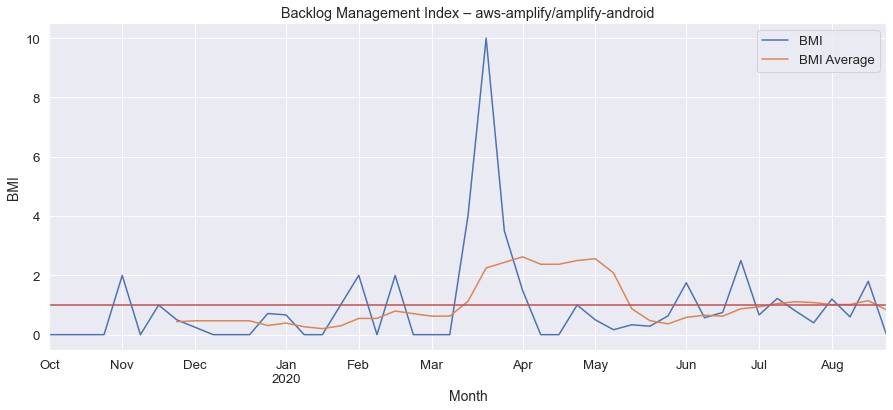

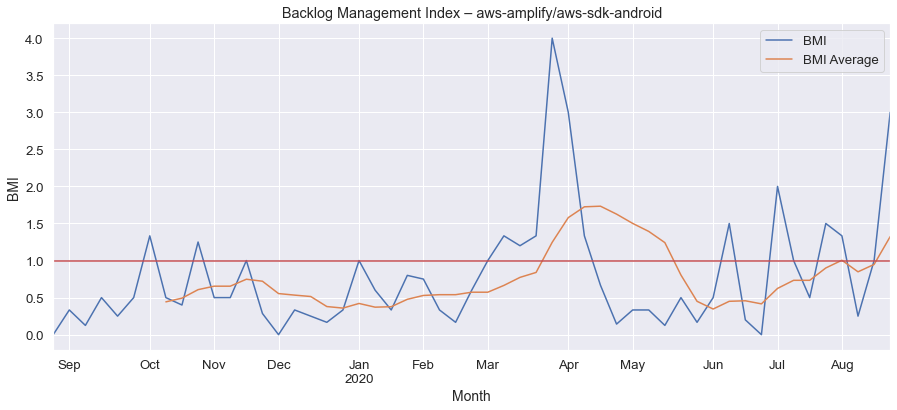

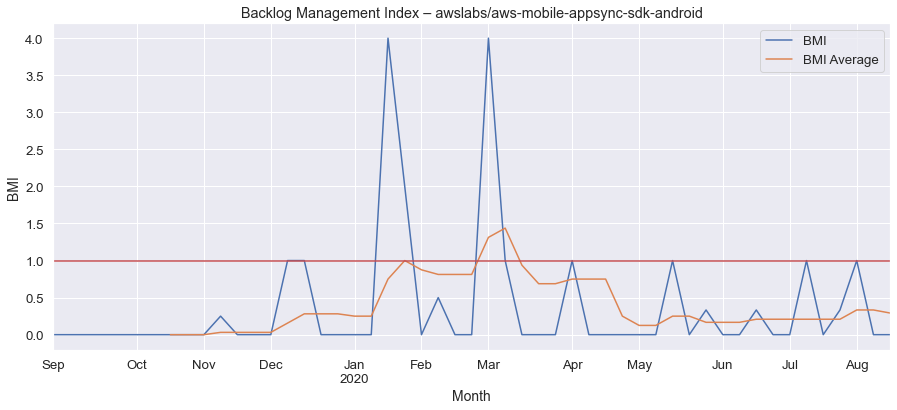

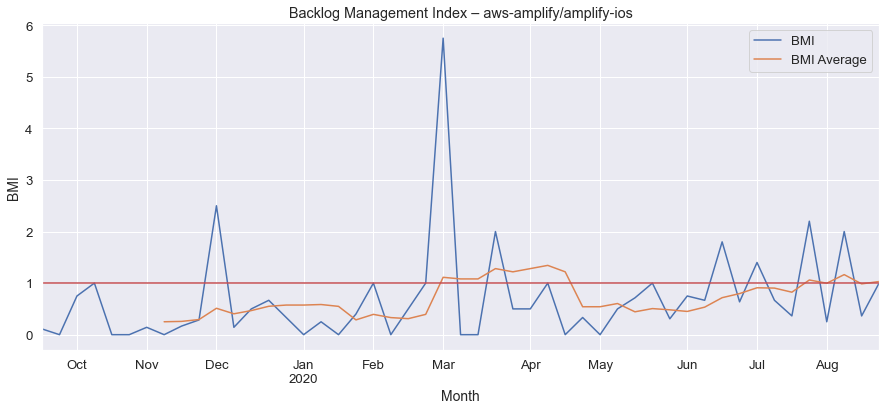

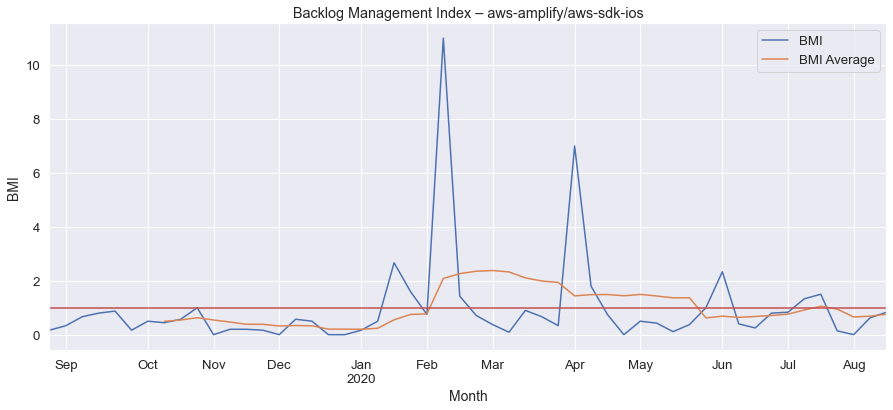

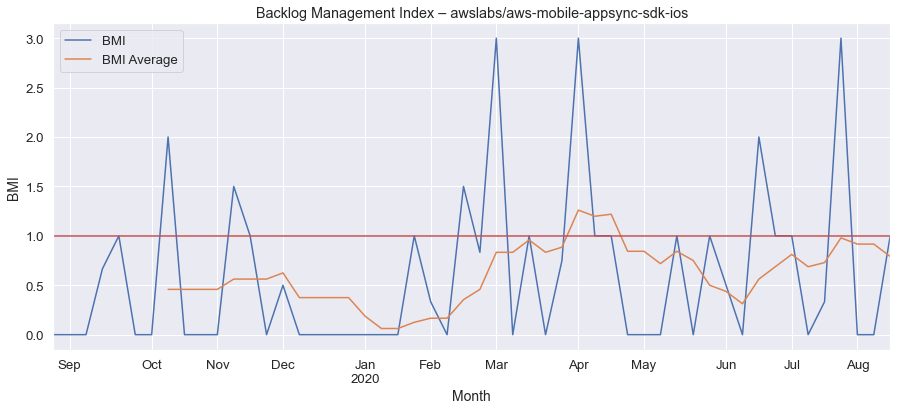

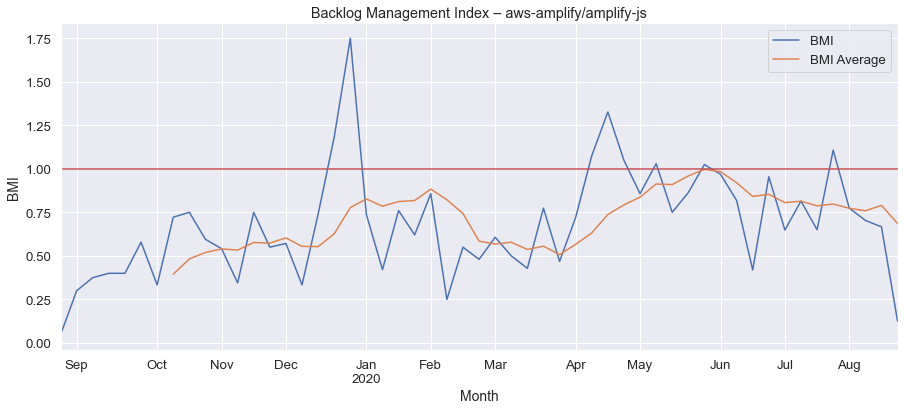

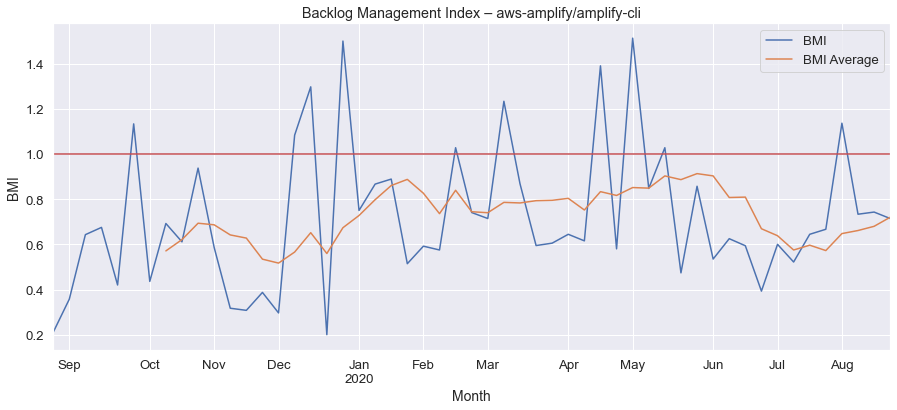

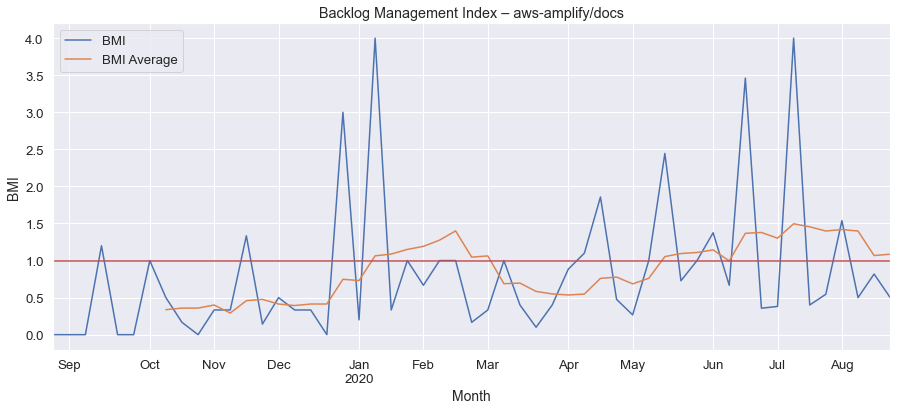

In [8]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Management Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

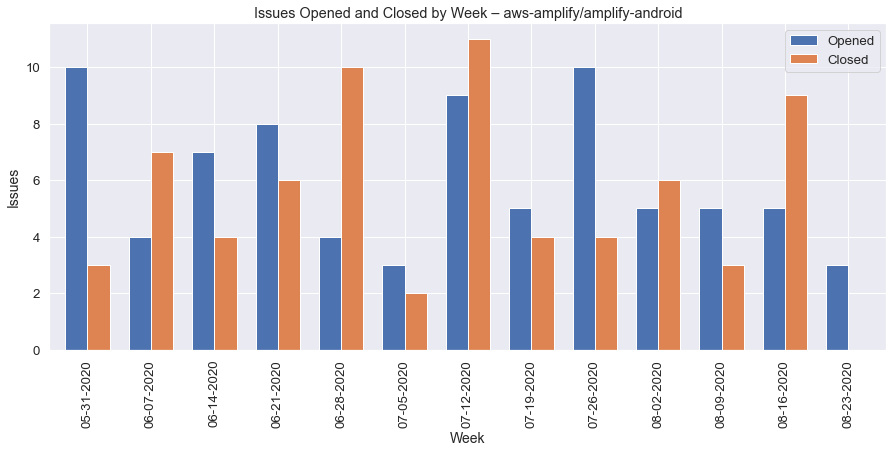

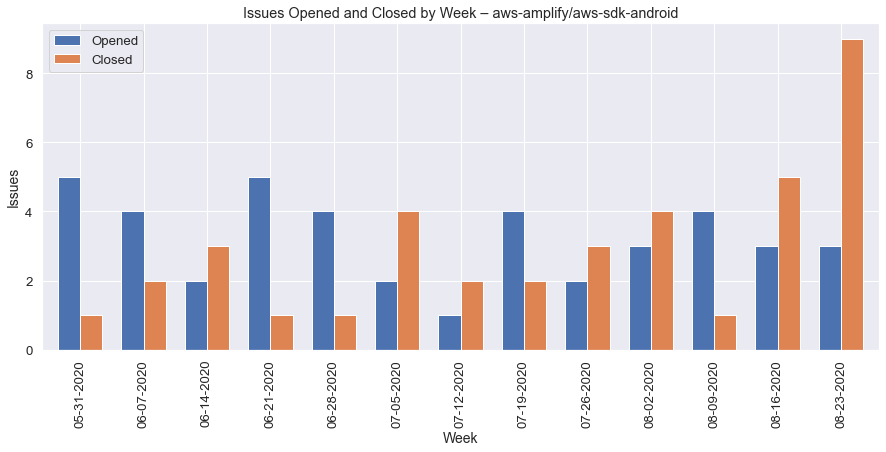

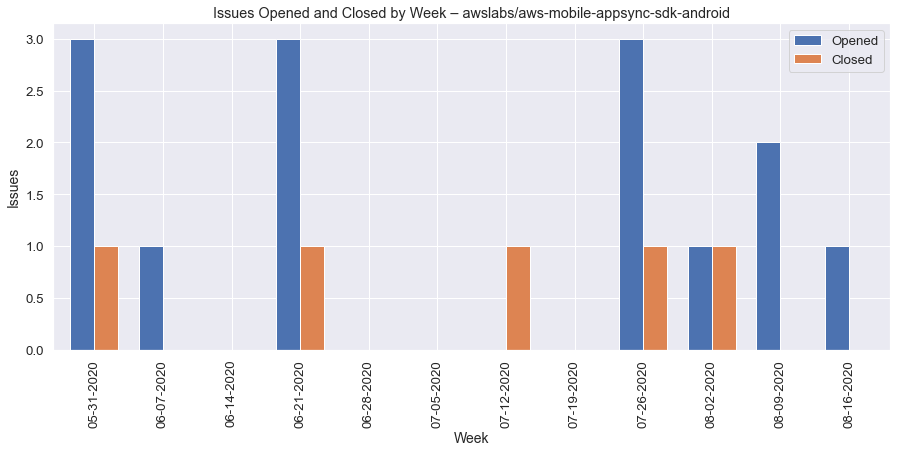

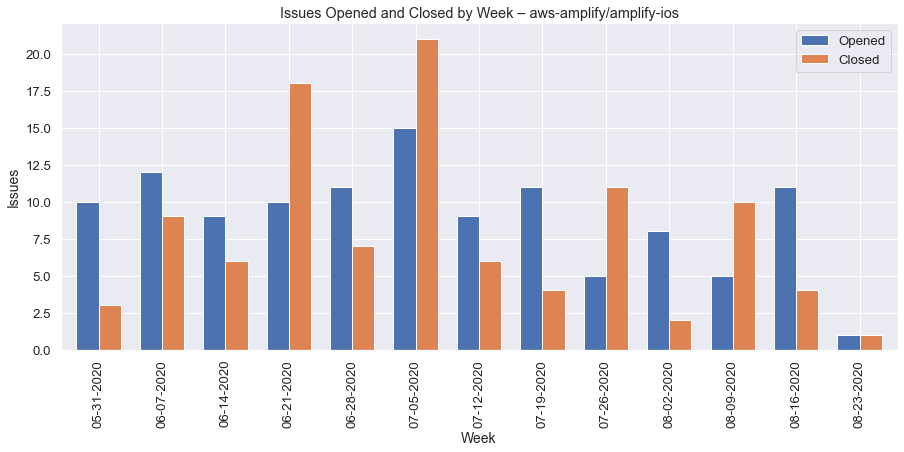

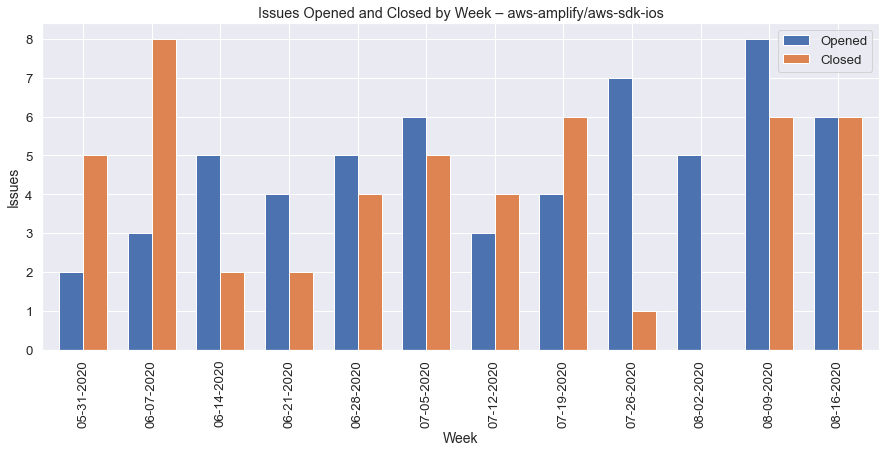

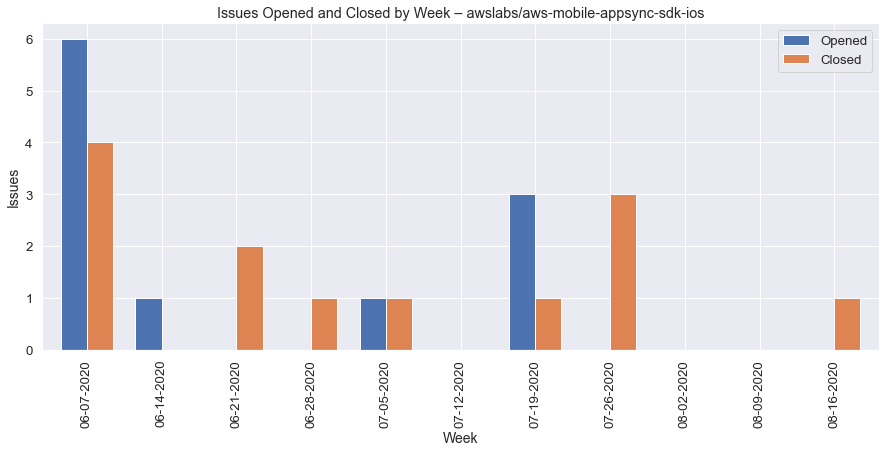

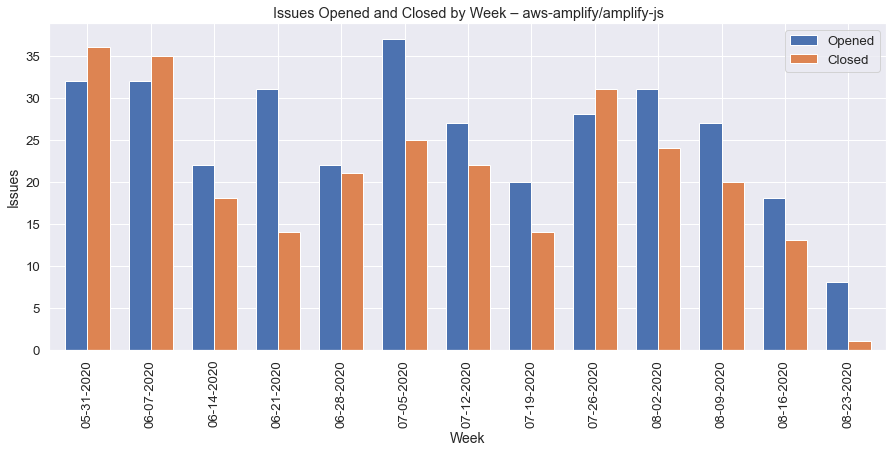

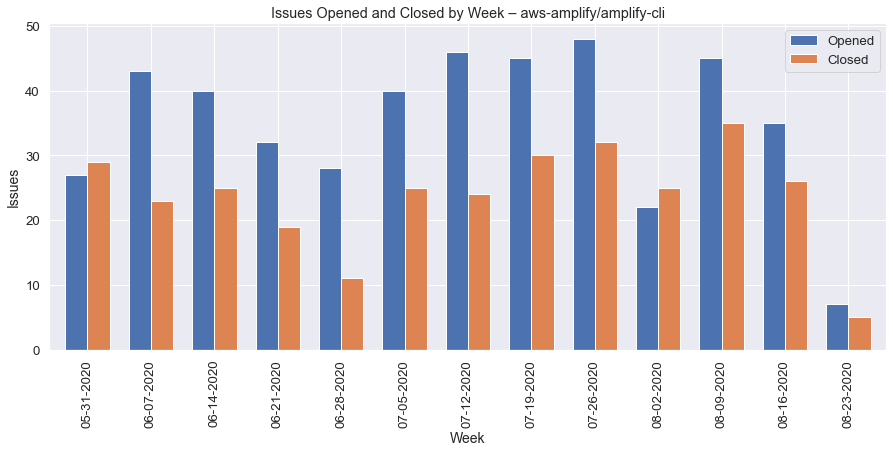

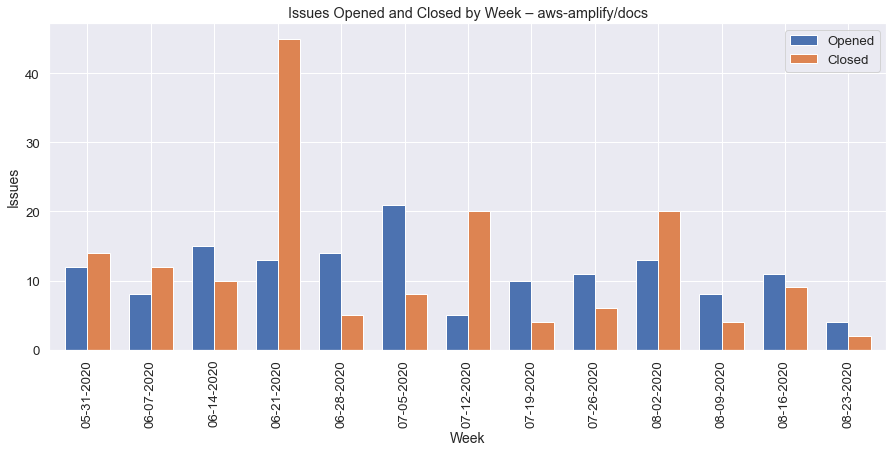

In [9]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

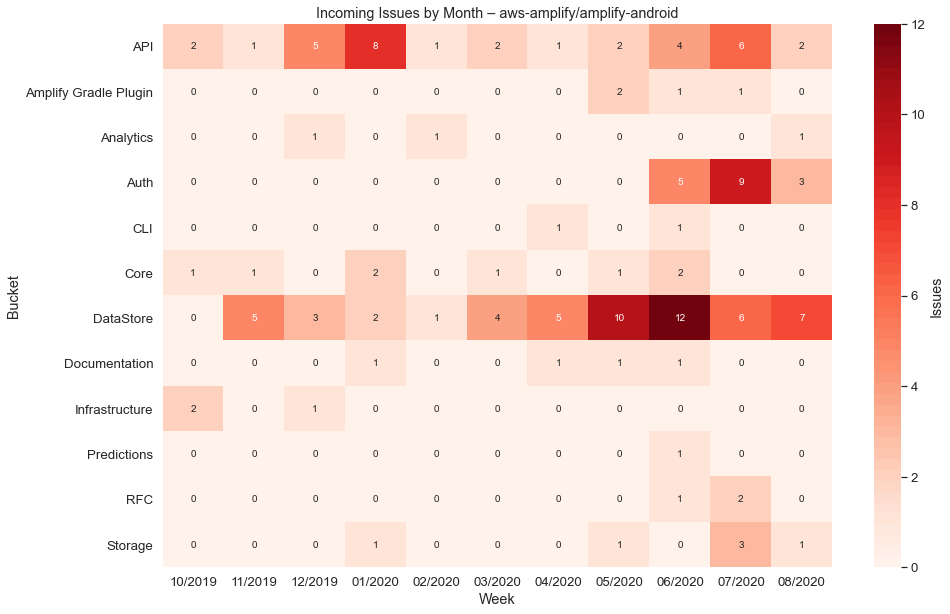

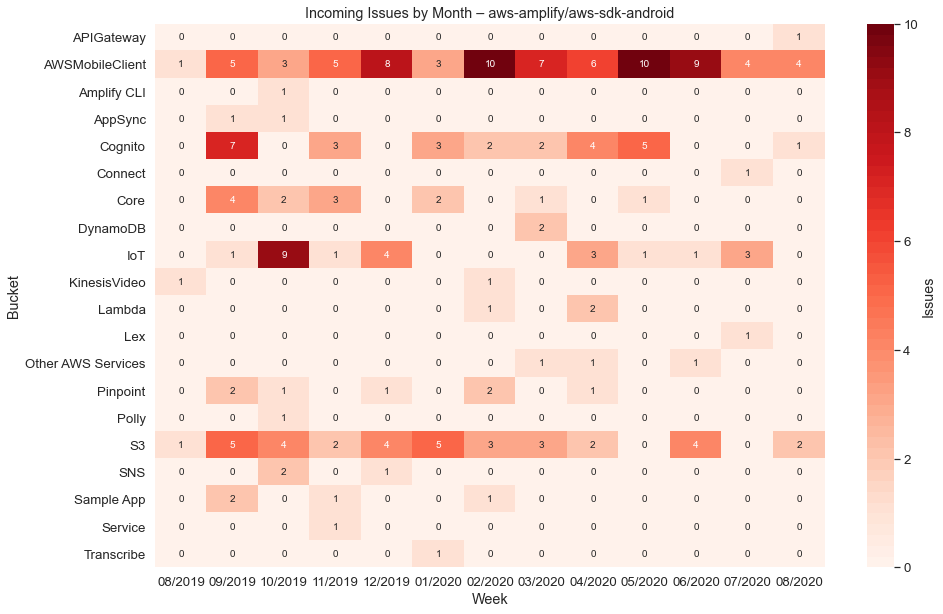

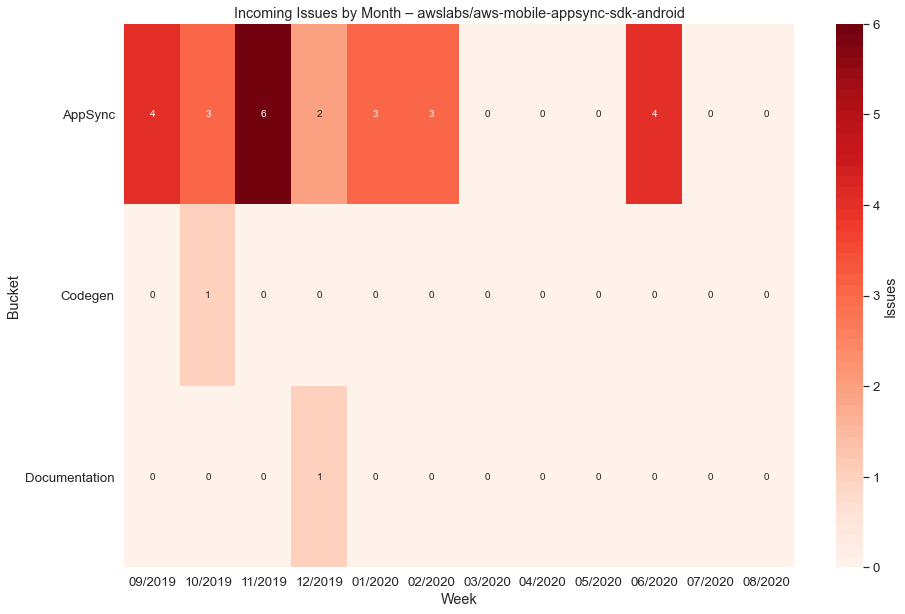

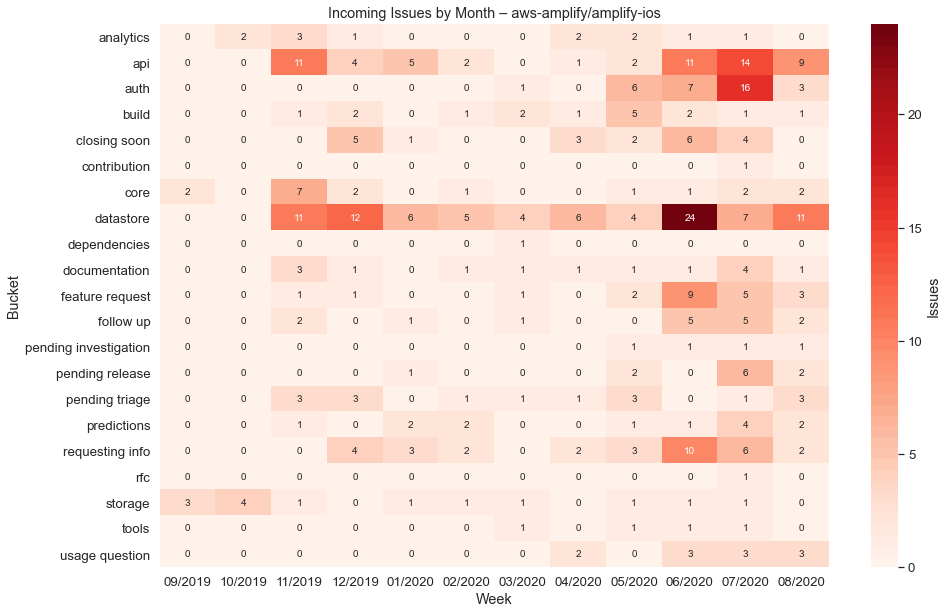

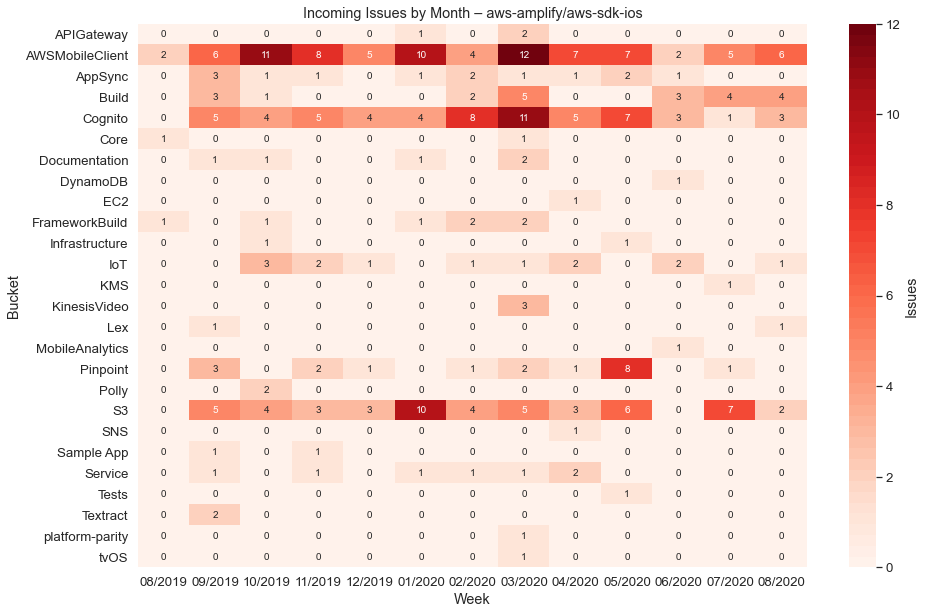

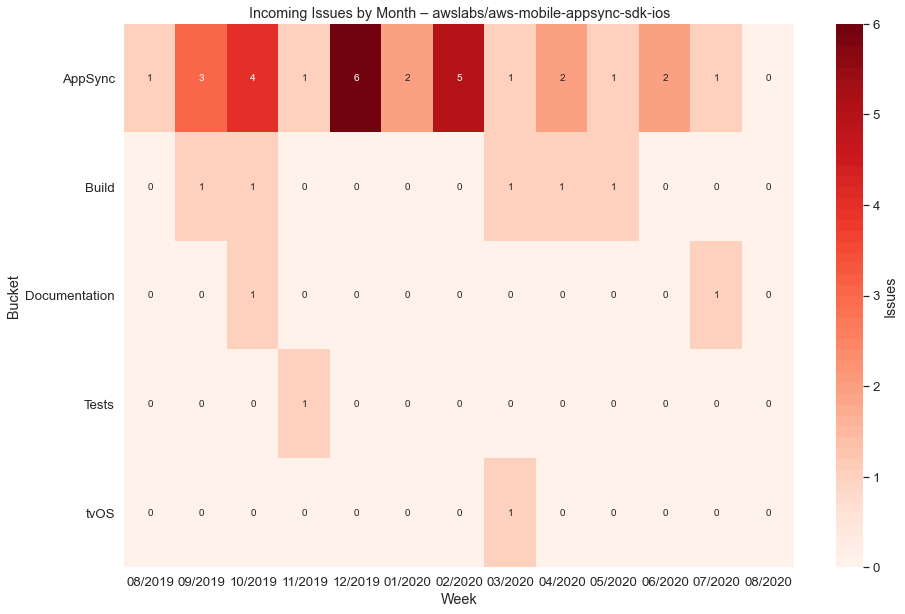

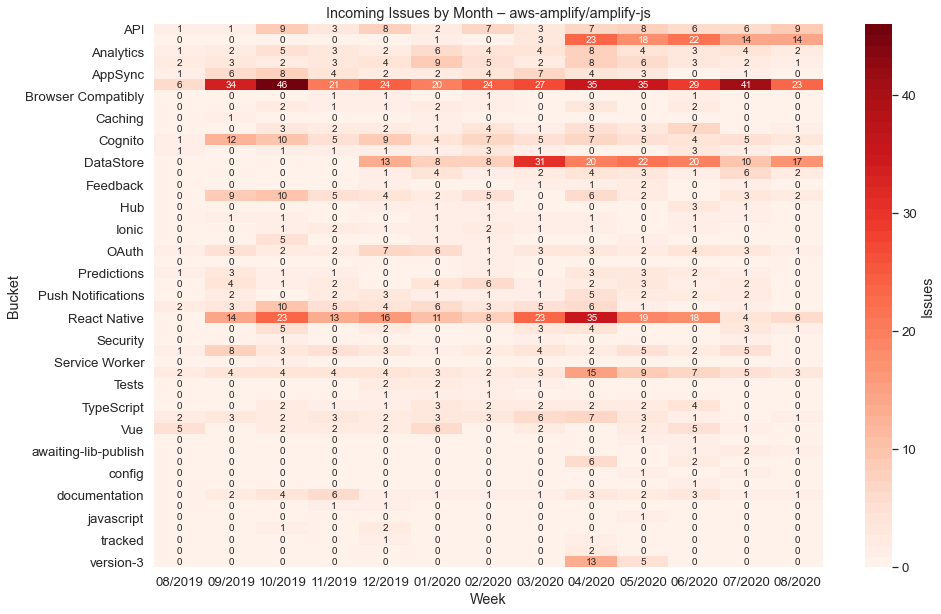

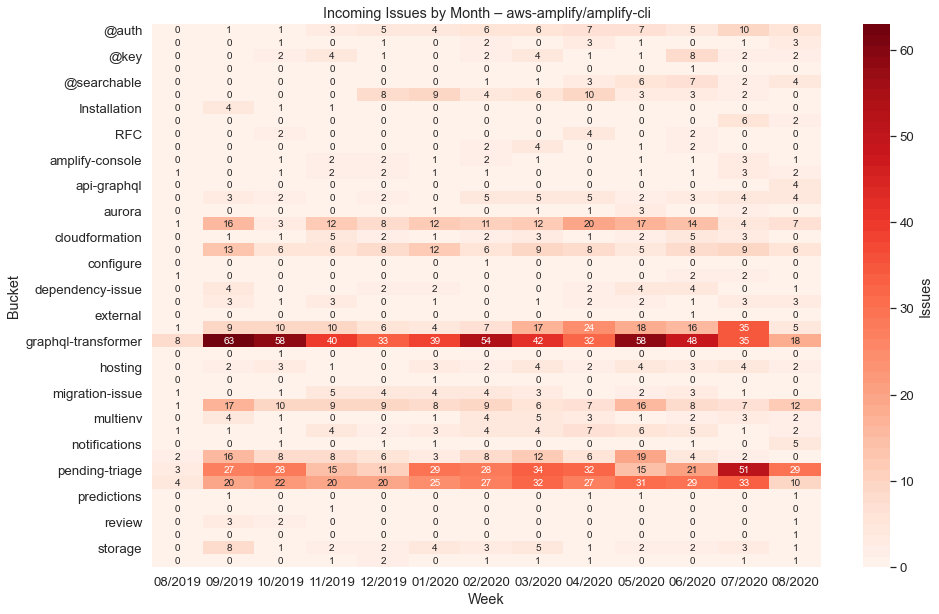

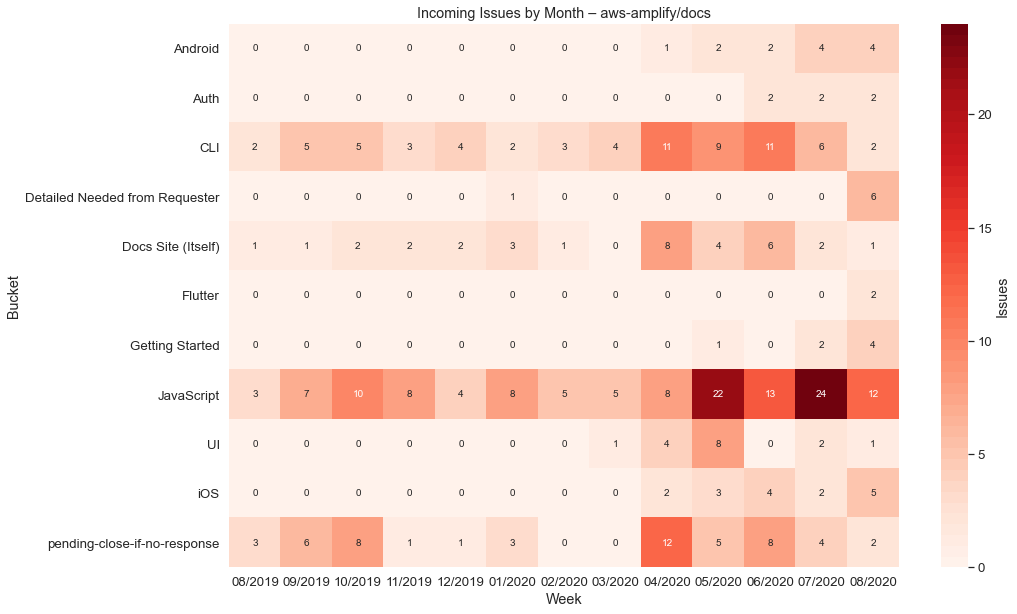

In [10]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

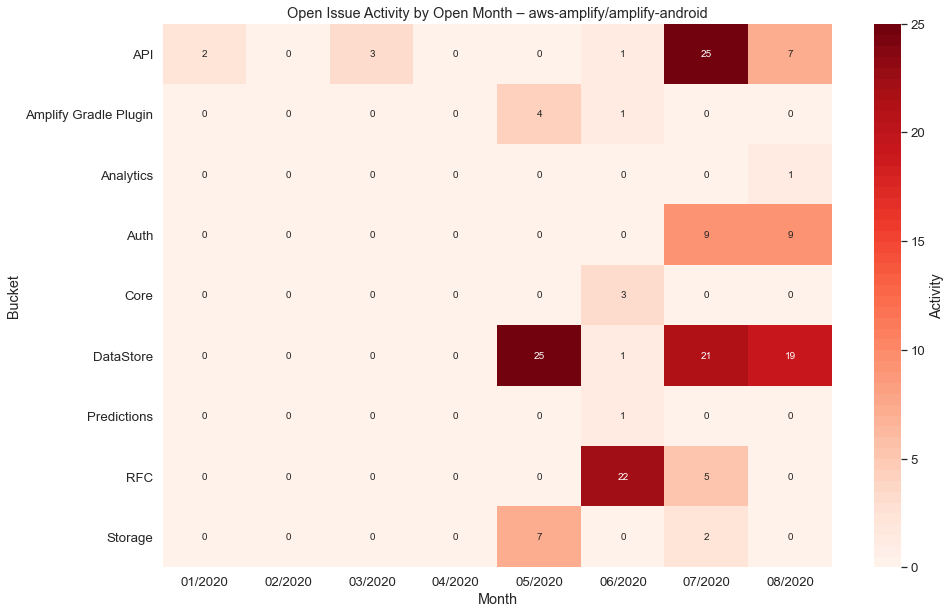

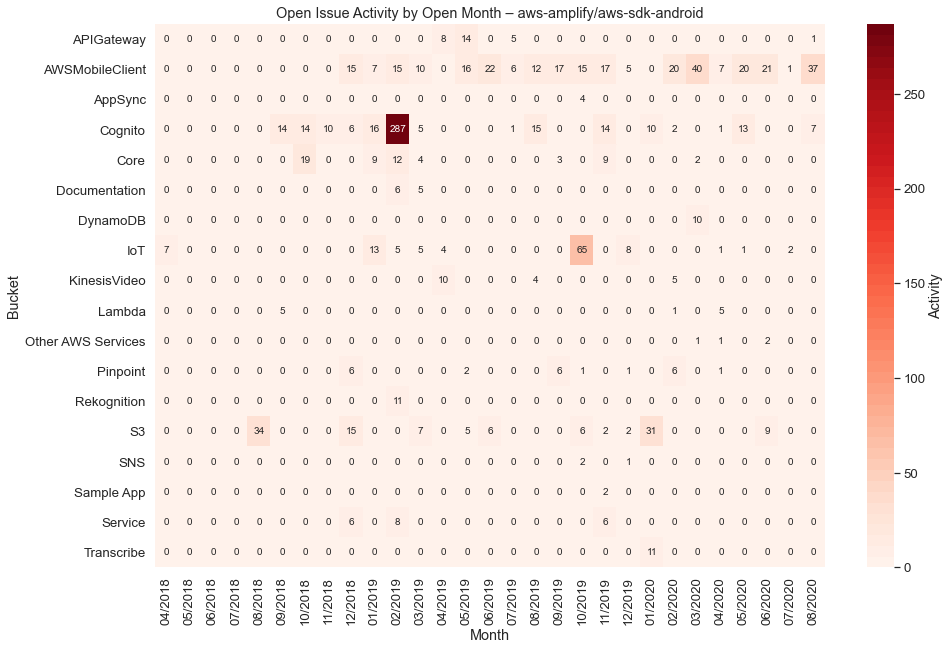

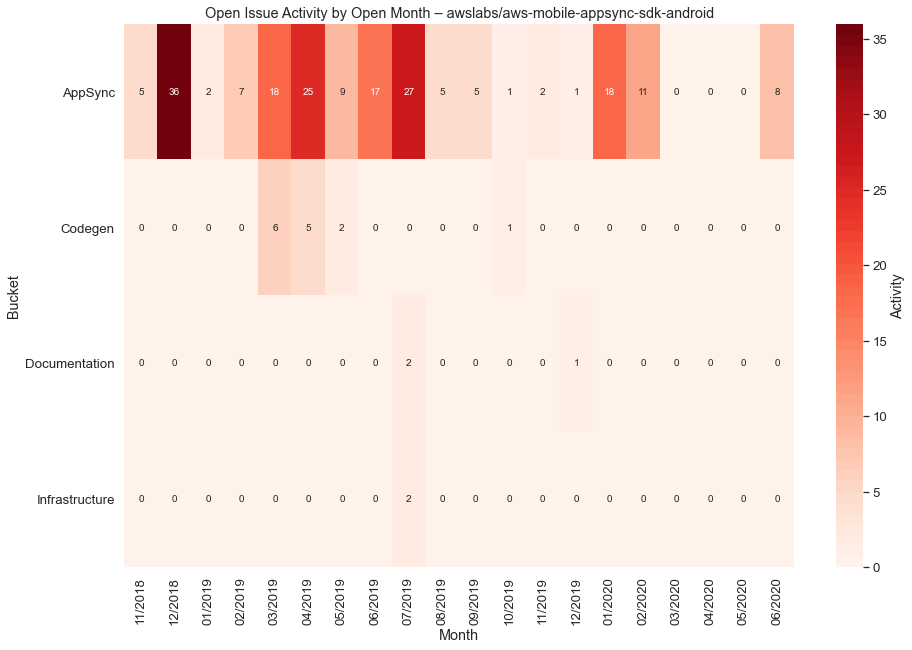

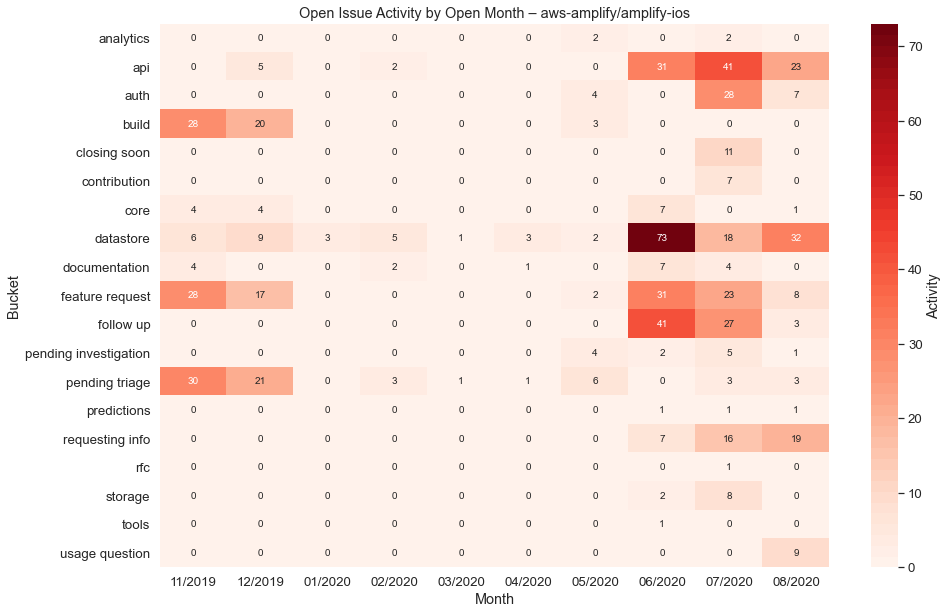

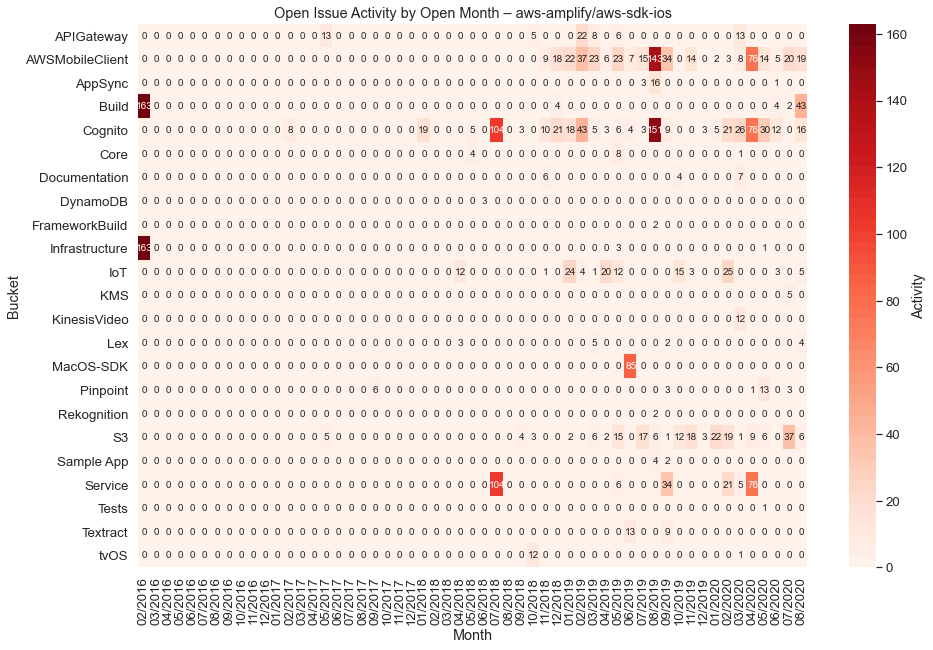

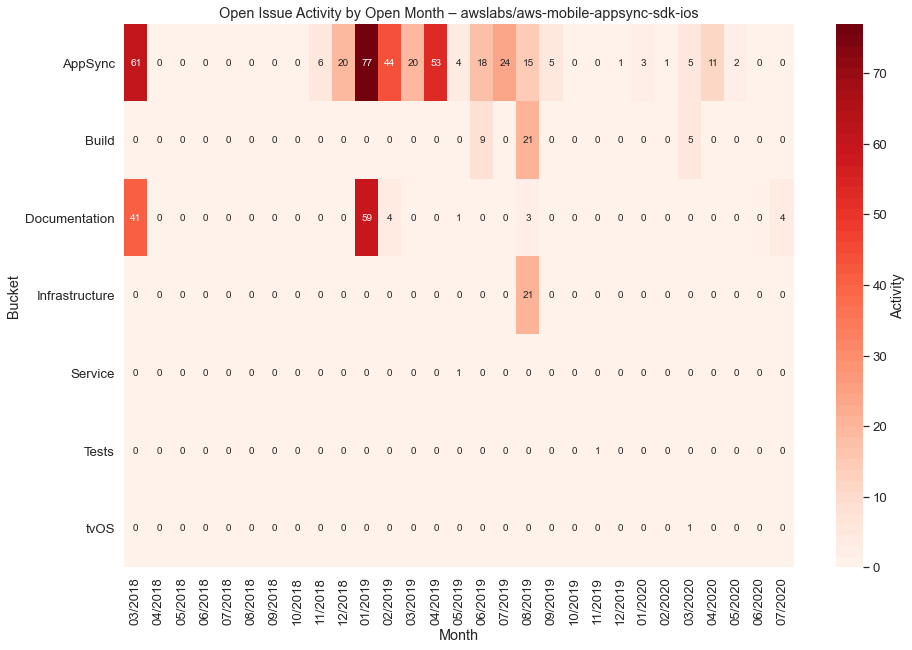

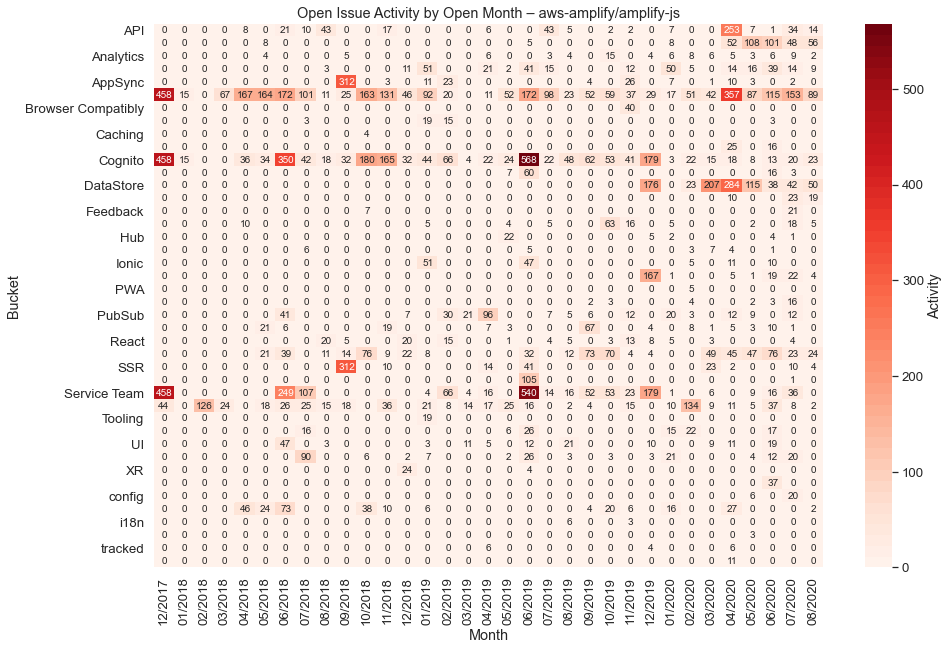

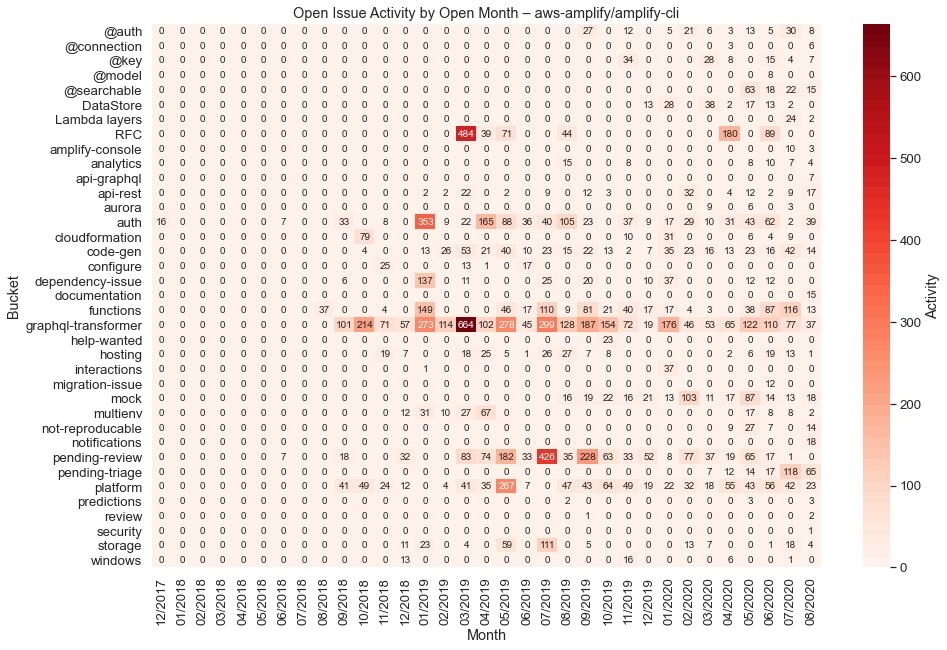

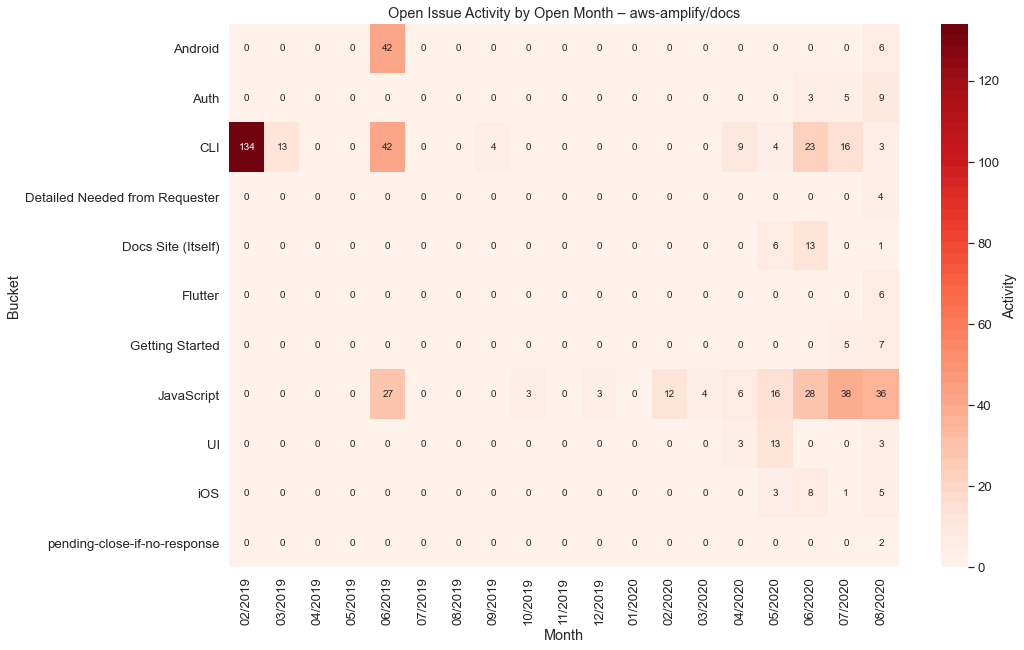

In [11]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [12]:
##### Closed Issue Report

from IPython.core.display import HTML

pd.set_option('display.max_colwidth', None)

display(HTML(f'<h1>Closed Issues</h1>'))

seven_days_ago = datetime.now() - pd.Timedelta('7 days')
seven_days_ago = seven_days_ago.astimezone(pytz.timezone('UTC'))

for repo_name, df in repos.items():
    df = df[(df.closed_at > seven_days_ago)]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']])

,id,title,created_at,labels,score
79,552,Sign in with web UI failed,2020-06-04 09:11:09+00:00,"[Auth, Bug]",25
100,595,"""E/SQLiteLog: (1) no such table: "" occurs when I use ""Amplify.DataStore.save()""",2020-06-24 05:59:06+00:00,"[Bug, DataStore]",20
119,646,Storage.uploadFile() and downloadFile() should provide a progress listener.,2020-07-16 15:55:40+00:00,"[Feature Request, Storage]",3
130,678,Can't use the Amplify.Auth.signInWithSocialWebUI without google chrome app installed/enabled.,2020-07-28 10:19:54+00:00,"[Auth, Feature Request]",2
150,745,Datastore not working when I manually run app from APK,2020-08-21 20:28:49+00:00,[],2
146,724,[DataStore] initial sync fails when using schema with belongs-to connection,2020-08-13 19:11:34+00:00,"[Bug, DataStore]",1


,id,title,created_at,labels,score
642,871,"""user cancelled"" exception",2019-04-05 03:25:55+00:00,"[AWSMobileClient, Cognito]",122
936,1722,AWSMobileClient getTokens is slow to return cached tokens,2020-05-11 12:59:37+00:00,[AWSMobileClient],43
609,764,AWS Cognito Android SDK MFA Authentication Issue,2019-03-04 07:18:02+00:00,"[Cognito, Feature Request]",19
917,1576,Resume a paused upload transfer can not receive onProgressChanged callback,2020-04-16 11:32:54+00:00,"[Bug, S3]",5
970,1976,Federate Google sign-in using Cognito user pool,2020-06-28 21:52:37+00:00,"[AWSMobileClient, Usage Question]",5
992,2088,Failed to upload file to S3 with AmazonS3Exception,2020-08-24 04:38:49+00:00,"[Bug, S3]",5
903,1524,HostedUIOptions for Facebook and Google opens white blank screen for few seconds,2020-03-21 04:25:45+00:00,"[AWSMobileClient, Feature Request]",4
935,1721,Cognito sign in with unconfirmed user throws different exception now,2020-05-10 18:59:39+00:00,"[AWSMobileClient, Bug]",4
954,1813,[Hosted UI] Can't use getUserAttributes() without the aws.cognito.signin.user.admin scope,2020-06-03 10:48:50+00:00,"[AWSMobileClient, Usage Question]",3
991,2087,"Getting error : Unable to calculate MD5 hash - EACCES (Permission denied)""",2020-08-21 14:08:15+00:00,"[Bug, S3]",3


,id,title,created_at,labels,score


,id,title,created_at,labels,score
261,717,Declaration 'resultPublisher' cannot override more than one superclass declaration,2020-08-17 17:18:27+00:00,"[documentation, pending release]",7
257,706,Lint and compiler warnings degrade quality of onboarding DX,2020-08-12 06:18:57+00:00,[enhancement],6
259,713,Protocol-defined APIs marked with `@discardableResult` don't propagate to implementations,2020-08-13 15:27:11+00:00,"[bug, core, pending release]",6
34,122,Verify SQLite limit to bind variables,2019-11-19 22:48:05+00:00,"[datastore, documentation, wontfix]",3
272,740,Declaration 'resultPublisher' cannot override more than one superclass declaration,2020-08-25 09:00:25+00:00,"[build, duplicate]",3


,id,title,created_at,labels,score
1321,1993,Support for Google Sign In SDK Version 5.0 and greater,2019-10-15 15:12:27+00:00,"[Cognito, Pending, feature-request]",29
1151,1513,AWSS3 progressBlock stops getting called after returning from upload in the background sometimes.,2019-04-29 18:53:19+00:00,"[S3, bug]",12
1584,2958,AWSMobileClient iOS Extension Compatibility,2020-08-19 09:08:21+00:00,"[AWSMobileClient, Duplicate, feature-request]",11
1491,2494,AwsMobileClient Signin will crash and ShowSignin not working on real device,2020-04-25 05:32:51+00:00,"[AWSMobileClient, Investigating, bug]",9
1583,2947,AWSMobileClient.default().username is nil at times,2020-08-16 07:52:28+00:00,"[AWSMobileClient, Requesting Feedback]",3


,id,title,created_at,labels,score
220,401,ObjC type Exception when using a enum in Subscription type on appSyncClient.subscribe,2020-07-21 03:24:28+00:00,"[AppSync, Bug, Investigating]",10


,id,title,created_at,labels,score
1145,1852,Flutter support,2018-10-06 02:26:17+00:00,[feature-request],2472
3738,6181,Users randomly getting ExpiredTokenExceptions and 403s on API calls,2020-06-26 19:18:52+00:00,"[API, Auth, React Native]",16
3888,6492,API 403 error on api-rest calls after recent upgrade,2020-08-04 23:58:13+00:00,"[API, to-be-reproduced]",10
3775,6252,UI-Components Sign Up assumes uncofirmed after sign up submit,2020-07-07 19:21:51+00:00,"[Amplify UI Components, needs-review, pending-close-response-required]",8
3808,6319,Generated code on multiple auth types not working.,2020-07-14 03:42:09+00:00,"[API, GraphQL, pending-close-response-required]",7
3776,6253,UI-Components Forgot Password submit button text does not change after code send,2020-07-07 19:35:53+00:00,"[Amplify UI Components, needs-review, pending-close-response-required]",5
3893,6506,"Amplify ""Network Error"" when doing Auth.signUp()",2020-08-05 20:53:57+00:00,"[Auth, React Native, pending-close-response-required]",5
3905,6534,[Request] DataStore models should have a sync status field,2020-08-07 20:22:10+00:00,"[DataStore, feature-request]",5
3953,6626,cypress can't select authenticator inputs for @aws-amplify/ui-react,2020-08-23 14:01:33+00:00,"[Amplify UI Components, question]",4
3937,6592,subscriptionError Connection failed ... Missing field argument owner when using OIDC,2020-08-17 04:37:12+00:00,"[Auth, DataStore, duplicate]",3


,id,title,created_at,labels,score
2390,3767,Incorrect variables,2020-03-25 19:13:41+00:00,"[functions, pending-close-response-required, pending-triage]",15
3132,4949,How to create PROD environment from my DEV environment?,2020-07-27 21:51:03+00:00,"[documentation, multienv, platform]",13
3021,4794,GraphQL real time subscriptions with shared ownership through auth rules,2020-07-10 13:10:29+00:00,"[@auth, graphql-transformer, question]",9
2358,3713,"GraphQLError: Syntax Error: Expected Name, found Int ""24""",2020-03-19 18:53:04+00:00,"[graphql-transformer, pending-close-response-required, pending-triage]",8
2482,3935,Amplify attempts to remove custom cloud formation stacks when adding a new trigger,2020-04-10 22:59:44+00:00,"[auth, not-reproducable]",8
3221,5075,command not found: amplify cli on mac,2020-08-13 04:23:21+00:00,"[platform, question]",7
3158,4984,Clarify usage of privacy.authRoleName and privacy.unAuthRoleName in api-params.json (REST api),2020-07-31 05:21:45+00:00,"[api-rest, pending-response, question]",6
3198,5044,Failed to start API Mock endpoint TypeErrorFailed to start API Mock endpoint TypeError,2020-08-10 09:58:58+00:00,[mock],6
3275,5155,Returning only required fields from AWS Amplify GraphQL Query,2020-08-23 08:46:48+00:00,[],5
3071,4864,Codegen for Android generates invalid syntax in CopyOfBuilder,2020-07-17 18:48:35+00:00,"[bug, code-gen]",5


,id,title,created_at,labels,score
549,2088,[Feedback]Keyword search in Framework docs behaves in unexpected ways,2020-07-09 20:01:03+00:00,"[Docs Site (Itself), pending-close-if-no-response]",7
538,2071,[Feedback]AmplifyAuthenticator -Does not pass props.authState children,2020-07-07 12:15:37+00:00,"[UI, pending-close-if-no-response]",4
541,2074,Improved Custom CloudFormation documentation,2020-07-07 19:25:20+00:00,[Feature Request],4
605,2265,"[Feedback] Minor issue - JavaScript docs say to ""Add the files to the Xcode project""",2020-08-19 18:19:55+00:00,[],4
591,2217,AWS Neophyte,2020-08-09 19:30:22+00:00,"[Detailed Needed from Requester, pending-close-if-no-response]",3
599,2243,[missing-page],2020-08-14 10:02:29+00:00,[Detailed Needed from Requester],3
606,2272,[Feedback] One Bracket too much in Amplify.Storage.uploadData example code,2020-08-20 13:19:58+00:00,[iOS],3
604,2257,[missing-page] Getting Started with Amplify Flutter,2020-08-19 04:32:08+00:00,[],2
612,2286,[Feedback]FEEDBACK_TITLE_HERE,2020-08-22 01:20:27+00:00,[],2
603,2255,Redirects documentation for SPA redirect is missing woff2 extension,2020-08-19 01:10:11+00:00,[],1


In [13]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))